In [53]:
import fiona
import pandas as pd, numpy as np, json
import geopandas as gpd
from geopandas import GeoDataFrame
from shapely.geometry import Point
from shapely.geometry import Polygon
import warnings
warnings.filterwarnings("ignore")
import datetime


pd.set_option("max_columns", 25)

%matplotlib inline

In [27]:
transitFiles = ["Rail", "Ferry", "BusHQT"]

bufferSizes = {
    "Rail" : [0.25, 0.5],
    "Ferry": [0.25, 0.5],
    "BusHQT": 0.25
}

km2mi = 1.60934
crs = {'init': 'epsg:4326'}

In [28]:
polys = []

for mode in transitFiles:
    path =  "https://raw.githubusercontent.com/simonhochberg/eight-two-seven/master/output/v3/All{}.csv".format(mode)
    print(path)
    
    df = pd.read_csv(path)
    df.drop(["Unnamed: 0", "Unnamed: 0.1"], axis=1, inplace=True)
    
    if mode == "BusHQT":
    
        bufferSize = bufferSizes[mode]

        df["buffer_dd"] = [(km2mi*(bufferSize))/((111.11 * np.cos(np.deg2rad(x)))) for x in df["stop_lat"]]

        geo = gpd.GeoSeries([Point(xy) for xy in zip(df['stop_lon'], df['stop_lat'])])

        df = gpd.GeoDataFrame(df, crs=crs, geometry=geo)
        df.crs = crs

        df_buffers = gpd.GeoDataFrame(df)
        df_buffers.crs = crs

        df_buffers['geometry'] = df_buffers.apply(lambda x: x.geometry.buffer(x.buffer_dd), axis=1)
        df_buffers["dissolve_dummy"] = np.zeros(len(df_buffers)) # value to use in dissolve

        df_dissolve = df_buffers[['dissolve_dummy', 'geometry']].dissolve(by="dissolve_dummy")

        outpath = "output/All{}-Buffers.csv".format(mode)
        df_buffers.to_csv(outpath)

        dissolve_outpath = "output/All{}-Buffers-Dissolve.csv".format(mode)
        df_dissolve.to_csv(dissolve_outpath)
        
        df_dissolve["poly"] = "{}".format(mode)
        
        polys.append(df_dissolve) 
    
    else:
        
        for bufferSize in bufferSizes[mode]:
            
            df["buffer_dd"] = [(km2mi*(bufferSize))/((111.11 * np.cos(np.deg2rad(x)))) for x in df["stop_lat"]]

            geo = gpd.GeoSeries([Point(xy) for xy in zip(df['stop_lon'], df['stop_lat'])])

            df = gpd.GeoDataFrame(df, crs=crs, geometry=geo)
            df.crs = crs

            df_buffers = gpd.GeoDataFrame(df)
            df_buffers.crs = crs

            df_buffers['geometry'] = df_buffers.apply(lambda x: x.geometry.buffer(x.buffer_dd), axis=1)
            df_buffers["dissolve_dummy"] = np.zeros(len(df_buffers)) # value to use in dissolve

            df_dissolve = df_buffers[['dissolve_dummy', 'geometry']].dissolve(by="dissolve_dummy")

            outpath = "output/All{}-Buffers.csv".format(mode)
            df_buffers.to_csv(outpath)

            dissolve_outpath = "output/All{}-Buffers-{}mi-Dissolve.csv".format(mode, bufferSize)
            df_dissolve.to_csv(dissolve_outpath)
            
            df_dissolve["poly"] = "{}-{}mi".format(mode,bufferSize)
            
            polys.append(df_dissolve)

https://raw.githubusercontent.com/simonhochberg/eight-two-seven/master/output/v3/AllRail.csv
https://raw.githubusercontent.com/simonhochberg/eight-two-seven/master/output/v3/AllFerry.csv
https://raw.githubusercontent.com/simonhochberg/eight-two-seven/master/output/v3/AllBusHQT.csv


In [40]:
# polys[0] -- Rail 0.25 mile
# polys[1] -- Rail 0.5 mile
# polys[2] -- Ferry 0.25 mile
# polys[3] -- Ferry 0.5 mile
# polys[4] -- BusHQT 0.25 mile

# Union 
quarterMileBuffers = gpd.overlay(polys[0], polys[2], how="union")
quarterMileBuffers["dissolve_dummy"] = np.zeros(len(quarterMileBuffers))
quarterMileBuffers_dissolved = quarterMileBuffers[["dissolve_dummy", "geometry"]].dissolve(by="dissolve_dummy")

print("unioned quarter-mile buffers")

# Union 1/2 mile rail and ferry transit buffers because they have the same upzoning impacts.

halfMileBuffers = gpd.overlay(polys[1], polys[3], how="union")
halfMileBuffers["dissolve_dummy"] = np.zeros(len(halfMileBuffers))
halfMileBuffers_dissolved = halfMileBuffers[["dissolve_dummy", "geometry"]].dissolve(by="dissolve_dummy")

print("unioned half-mile buffers")
# Take the difference between 1/4 mile major-transit stop buffers and 1/2 mile major-transit stop buffers
# RESULT: 1/2 mile major-transit stop buffer layer with holes

#halfMileBuffers_dissolved_HOLES = gpd.overlay(halfMileBuffers_dissolved, polys[0], how="difference")

unioned quarter-mile buffers
unioned half-mile buffers


In [41]:
# Take the difference between 1/4 mile major-transit stop buffers and 1/2 mile major-transit stop buffers
# RESULT: 1/2 mile major-transit stop buffer layer with holes

halfMileBuffers_dissolved_HOLES = gpd.overlay(halfMileBuffers_dissolved, quarterMileBuffers_dissolved, how="difference")
halfMileBuffers_dissolved_HOLES["dissolve_dummy"] = np.zeros(len(halfMileBuffers_dissolved_HOLES))
halfMileBuffers_dissolved_HOLES_dissolved = halfMileBuffers_dissolved_HOLES[["dissolve_dummy", "geometry"]].dissolve(by="dissolve_dummy")



print("took difference between half-mile buffers and quarter-mile buffers")

took difference between half-mile buffers and quarter-mile buffers


In [43]:
# take the difference between 1/4 mile bus stop buffers and 1/2 mile major-transit stop buffers
busStopBuffers_HOLES = gpd.overlay(polys[4], halfMileBuffers_dissolved, how="difference")
busStopBuffers_HOLES["dissolve_dummy"] = np.zeros(len(busStopBuffers_HOLES))
busStopBuffers_HOLES_dissolved = busStopBuffers_HOLES[["dissolve_dummy", "geometry"]].dissolve(by="dissolve_dummy")


print("took the difference between bus layer and half-mile buffers")

took the difference between bus layer and half-mile buffers


In [44]:
layer_polys = [quarterMileBuffers_dissolved, halfMileBuffers_dissolved_HOLES_dissolved, busStopBuffers_HOLES_dissolved]

In [38]:
busStopBuffers_HOLES.head()

,poly,geometry
0,BusHQT,POLYGON ((-117.2404437277679 32.86849446143501...
1,BusHQT,"POLYGON ((-117.2564224255261 32.9358962954, -1..."
2,BusHQT,"POLYGON ((-117.256406506361 32.94788827409999,..."
3,BusHQT,"POLYGON ((-117.215331749443 32.86841359313539,..."
4,BusHQT,"POLYGON ((-117.2632363652522 32.9688585354, -1..."


In [51]:
transitRichAreas = gpd.GeoDataFrame(pd.concat(layer_polys), geometry="geometry")
transitRichAreas.crs = {'init': 'epsg:4326'}

transitRichAreas3857 = transitRichAreas.to_crs({'init': 'epsg:3857'})

In [58]:
str(datetime.datetime.today()).split()[0]

'2019-04-09'

In [60]:
filename = "output/TransitRichAreas_3857_created:{}.geojson".format(str(datetime.datetime.today()).split()[0])
transitRichAreas3857.to_file(filename=filename, driver="GeoJSON")

In [50]:
transitRichAreas.crs

{'init': 'epsg:4326'}

In [32]:
polys[4]

,geometry,poly
dissolve_dummy,,
0.0,(POLYGON ((-117.215331749443 32.86841359313539...,BusHQT


In [11]:
gpd.overlay(polys[3], 

,geometry,poly
dissolve_dummy,,
0.0,(POLYGON ((-117.215331749443 32.86841359313539...,BusHQT


In [4]:
tracts = gpd.read_file("tl_2018_06_tract_4326.shp")
tracts = tracts[["GEOID", "geometry"]]

In [6]:
tracts.head()

,GEOID,geometry
0,06037137504,"POLYGON ((-118.581186 34.14317599999999, -118...."
1,06037138000,"POLYGON ((-118.60573 34.14585399999999, -118.6..."
2,06037139200,"POLYGON ((-118.530824 34.18023599999999, -118...."
3,06067002300,"POLYGON ((-121.502176 38.55643399999999, -121...."
4,06067002400,"POLYGON ((-121.509697 38.54069899999999, -121...."


In [8]:
tracts["county"] = tracts["GEOID"].str[2:5]

In [95]:


counties = tracts.dissolve(by="county")

counties.head()

KeyboardInterrupt: 

In [96]:
adjacents = []

for index, row in counties.iterrows():  
    print(index, row)
    neighbors = list(counties[counties.geometry.touches(row['geometry'])].index)
    #neighbors = neighbors.remove(row.name)
    adjacents.append(neighbors)

counties["adjacent"] = adjacents

001 geometry    POLYGON ((-122.044587 37.46066599999999, -122....
GEOID                                             06001441402
adjacent                       [013, 075, 077, 081, 085, 099]
Name: 001, dtype: object
003 geometry    POLYGON ((-120.073331 38.70108999999999, -120....
GEOID                                             06003010000
adjacent                            [005, 009, 017, 051, 109]
Name: 003, dtype: object
005 geometry    POLYGON ((-120.541304 38.42291099999999, -120....
GEOID                                             06005000102
adjacent                            [003, 009, 017, 067, 077]
Name: 005, dtype: object
007 geometry    POLYGON ((-121.908697 39.30798999999998, -121....
GEOID                                             06007001703
adjacent                       [011, 021, 063, 101, 103, 115]
Name: 007, dtype: object
009 geometry    POLYGON ((-120.376203 38.14264899999999, -120....
GEOID                                             06009000210
adjacent    

079 geometry    POLYGON ((-120.086674 35.52655399999999, -120....
GEOID                                             06079010205
adjacent                                 [029, 031, 053, 083]
Name: 079, dtype: object
081 geometry    POLYGON ((-122.162695 37.45384399999998, -122....
GEOID                                             06081610700
adjacent                                 [001, 075, 085, 087]
Name: 081, dtype: object
083 geometry    (POLYGON ((-119.117174 33.50559999999999, -119...
GEOID                                             06083000301
adjacent                                      [029, 079, 111]
Name: 083, dtype: object
085 geometry    POLYGON ((-121.471151 36.97797399999998, -121....
GEOID                                             06085504700
adjacent                       [001, 047, 069, 081, 087, 099]
Name: 085, dtype: object
087 geometry    POLYGON ((-121.738697 36.98999099999999, -121....
GEOID                                             06087121500
adjacent    

In [97]:
counties.head()

,geometry,GEOID,adjacent
county,,,
001,"POLYGON ((-122.044587 37.46066599999999, -122....",06001441402,"[013, 075, 077, 081, 085, 099]"
003,"POLYGON ((-120.073331 38.70108999999999, -120....",06003010000,"[005, 009, 017, 051, 109]"
005,"POLYGON ((-120.541304 38.42291099999999, -120....",06005000102,"[003, 009, 017, 067, 077]"
007,"POLYGON ((-121.908697 39.30798999999998, -121....",06007001703,"[011, 021, 063, 101, 103, 115]"
009,"POLYGON ((-120.376203 38.14264899999999, -120....",06009000210,"[003, 005, 077, 099, 109]"


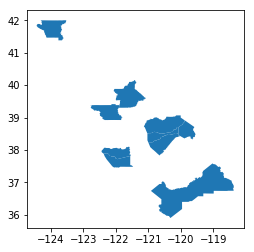

In [29]:
counties.head(10).plot()

In [32]:
acTest = df[df["agency"] == "AC Transit"]

In [35]:
acTest.head()

,stop_id,stop_name,stop_lon,stop_lat,am_pk,pm_pk,wkdy,sat,sun,agency,buffer_dd,geometry
4169,100340,Blanding Av:Broadway,-122.233770,37.768581,10.909091,9.230769,11.034483,16.153846,16.470588,AC Transit,0.004581,POINT (-122.23377 37.7685807)
4170,100460,Broadway:Santa Clara Av,-122.238062,37.763731,10.909091,8.888889,10.666667,16.153846,16.153846,AC Transit,0.004580,POINT (-122.2380619 37.763731)
4171,100470,Broadway:Tilden Way,-122.235163,37.767460,10.909091,10.434783,11.851852,17.872340,18.666667,AC Transit,0.004581,POINT (-122.2351626 37.7674598)
4172,102050,Marina Village Pkwy:Mariner Sq Loop,-122.277502,37.788309,12.000000,12.631579,13.521127,15.000000,15.000000,AC Transit,0.004582,POINT (-122.2775025 37.7883089)
4173,102830,Park St:San Jose Av,-122.245837,37.760801,15.000000,15.000000,15.000000,15.000000,15.000000,AC Transit,0.004580,POINT (-122.245837 37.7608012)


Assign counties to stops.

In [59]:
stopCTY = []

for i in df.index:
    
    pt = df.loc[i, "geometry"]
    
    checker = counties.contains(pt)
    
    
    stopCTY.append(checker.index[[i for i, x in enumerate(checker) if x]][0])
    #print(cty)
    

In [61]:
df["county"] = stopCTY

In [64]:
df["county"].value_counts()

037    5234
075    1975
001    1023
059     325
073     287
081     160
071     143
019     111
065     110
085      99
013      62
029      62
087      58
067      43
111      32
053      31
041      21
077      11
113       4
099       3
051       2
095       2
097       1
079       1
Name: county, dtype: int64

In [65]:
df["agency"].value_counts()

Metro - Los Angeles                              3943
San Francisco Municipal Transportation Agency    1977
AC Transit                                       1050
Long Beach Transit                                486
Orange County Transportation Authority            328
North County Transit District                     287
Culver CityBus                                    225
Big Blue Bus                                      201
LADOT                                             177
Foothill Transit                                  160
SamTrans                                          150
OMNITRANS                                         139
Fresno Public Transportation                      111
VTA                                                94
Riverside Transit Agency                           79
Santa Cruz Metro                                   58
Sacramento Regional Transit                        42
Gold Coast Transit                                 32
San Francisco Bay Ferry     

In [68]:
pd.crosstab(df["agency"], df["county"])

county,001,013,019,029,037,041,051,053,059,065,067,071,073,075,077,079,081,085,087,095,097,099,111,113
agency,,,,,,,,,,,,,,,,,,,,,,,,
AC Transit,993,55,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0
Big Blue Bus,0,0,0,0,201,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
City of Lodi Transit-GrapeLine,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
City of San Luis Obispo Transit,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
County Connection,0,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Culver CityBus,0,0,0,0,225,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Eastern Sierra Transit Authority,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Emery Go-Round,22,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Foothill Transit,0,0,0,0,155,0,0,0,0,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0


In [146]:
tracts.head()

,GEOID,geometry,county
0,06037137504,"POLYGON ((-118.581186 34.14317599999999, -118....",037
1,06037138000,"POLYGON ((-118.60573 34.14585399999999, -118.6...",037
2,06037139200,"POLYGON ((-118.530824 34.18023599999999, -118....",037
3,06067002300,"POLYGON ((-121.502176 38.55643399999999, -121....",067
4,06067002400,"POLYGON ((-121.509697 38.54069899999999, -121....",067


In [172]:
overlaps = {}

for cty in list(tracts["county"].unique())[1:2]:
    countyTracts = tracts[tracts["county"] == cty]
    
    print(cty, len(countyTracts))
    
    intersections = []

    for i in countyTracts.index[:]:
        #if i % 100 == 0:
            #print(i)

        centroid = countyTracts.loc[i, "geometry"].centroid
        centroidXY = [float(x) for x in str(centroid)[7:-1].split()]

        searchDistance = 2 / ((111.11*np.cos(np.deg2rad(centroidXY[1])))/ 1.60934)

        query = "(stop_lon - centroidXY[0]) > 1"

        eligibleStops = df_buffers[(np.abs(df_buffers["stop_lon"] - centroidXY[0]) <= searchDistance) & (np.abs(df_buffers["stop_lat"] - centroidXY[1]) <= searchDistance)]

        #print(len(eligibleStops))

        indvTract = countyTracts[countyTracts["GEOID"] == countyTracts.loc[i, "GEOID"]]


        intersection = gpd.overlay(indvTract, eligibleStops, how='intersection')


        if len(intersection) > 0:
            intersections.append(intersection)
        else:
            pass
    
    
    overlaps[cty] = pd.concat(intersections).dissolve("GEOID")
    

067 317


Exception ignored in: <bound method Handle.__del__ of <rtree.index.IndexStreamHandle object at 0x7f71f1dceef0>>
Traceback (most recent call last):
  File "/srv/app/venv/lib/python3.6/site-packages/rtree/index.py", line 875, in __del__
    self.destroy()
  File "/srv/app/venv/lib/python3.6/site-packages/rtree/index.py", line 863, in destroy
    if self._ptr is not None:
AttributeError: 'IndexStreamHandle' object has no attribute '_ptr'
Exception ignored in: <bound method Handle.__del__ of <rtree.index.IndexStreamHandle object at 0x7f71f1dce278>>
Traceback (most recent call last):
  File "/srv/app/venv/lib/python3.6/site-packages/rtree/index.py", line 875, in __del__
    self.destroy()
  File "/srv/app/venv/lib/python3.6/site-packages/rtree/index.py", line 863, in destroy
    if self._ptr is not None:
AttributeError: 'IndexStreamHandle' object has no attribute '_ptr'
Exception ignored in: <bound method Handle.__del__ of <rtree.index.IndexStreamHandle object at 0x7f71f1db8ef0>>
Traceback 

Exception ignored in: <bound method Handle.__del__ of <rtree.index.IndexStreamHandle object at 0x7f71f1dacc88>>
Traceback (most recent call last):
  File "/srv/app/venv/lib/python3.6/site-packages/rtree/index.py", line 875, in __del__
    self.destroy()
  File "/srv/app/venv/lib/python3.6/site-packages/rtree/index.py", line 863, in destroy
    if self._ptr is not None:
AttributeError: 'IndexStreamHandle' object has no attribute '_ptr'
Exception ignored in: <bound method Handle.__del__ of <rtree.index.IndexStreamHandle object at 0x7f721e466208>>
Traceback (most recent call last):
  File "/srv/app/venv/lib/python3.6/site-packages/rtree/index.py", line 875, in __del__
    self.destroy()
  File "/srv/app/venv/lib/python3.6/site-packages/rtree/index.py", line 863, in destroy
    if self._ptr is not None:
AttributeError: 'IndexStreamHandle' object has no attribute '_ptr'
Exception ignored in: <bound method Handle.__del__ of <rtree.index.IndexStreamHandle object at 0x7f71f1e2aef0>>
Traceback 

Exception ignored in: <bound method Handle.__del__ of <rtree.index.IndexStreamHandle object at 0x7f71f1db21d0>>
Traceback (most recent call last):
  File "/srv/app/venv/lib/python3.6/site-packages/rtree/index.py", line 875, in __del__
    self.destroy()
  File "/srv/app/venv/lib/python3.6/site-packages/rtree/index.py", line 863, in destroy
    if self._ptr is not None:
AttributeError: 'IndexStreamHandle' object has no attribute '_ptr'
Exception ignored in: <bound method Handle.__del__ of <rtree.index.IndexStreamHandle object at 0x7f71f1db21d0>>
Traceback (most recent call last):
  File "/srv/app/venv/lib/python3.6/site-packages/rtree/index.py", line 875, in __del__
    self.destroy()
  File "/srv/app/venv/lib/python3.6/site-packages/rtree/index.py", line 863, in destroy
    if self._ptr is not None:
AttributeError: 'IndexStreamHandle' object has no attribute '_ptr'
Exception ignored in: <bound method Handle.__del__ of <rtree.index.IndexStreamHandle object at 0x7f71f1db2320>>
Traceback 

Exception ignored in: <bound method Handle.__del__ of <rtree.index.IndexStreamHandle object at 0x7f71f1d9ddd8>>
Traceback (most recent call last):
  File "/srv/app/venv/lib/python3.6/site-packages/rtree/index.py", line 875, in __del__
    self.destroy()
  File "/srv/app/venv/lib/python3.6/site-packages/rtree/index.py", line 863, in destroy
    if self._ptr is not None:
AttributeError: 'IndexStreamHandle' object has no attribute '_ptr'
Exception ignored in: <bound method Handle.__del__ of <rtree.index.IndexStreamHandle object at 0x7f71f1e9cc50>>
Traceback (most recent call last):
  File "/srv/app/venv/lib/python3.6/site-packages/rtree/index.py", line 875, in __del__
    self.destroy()
  File "/srv/app/venv/lib/python3.6/site-packages/rtree/index.py", line 863, in destroy
    if self._ptr is not None:
AttributeError: 'IndexStreamHandle' object has no attribute '_ptr'
Exception ignored in: <bound method Handle.__del__ of <rtree.index.IndexStreamHandle object at 0x7f71f1e9c710>>
Traceback 

Exception ignored in: <bound method Handle.__del__ of <rtree.index.IndexStreamHandle object at 0x7f71f1e17da0>>
Traceback (most recent call last):
  File "/srv/app/venv/lib/python3.6/site-packages/rtree/index.py", line 875, in __del__
    self.destroy()
  File "/srv/app/venv/lib/python3.6/site-packages/rtree/index.py", line 863, in destroy
    if self._ptr is not None:
AttributeError: 'IndexStreamHandle' object has no attribute '_ptr'
Exception ignored in: <bound method Handle.__del__ of <rtree.index.IndexStreamHandle object at 0x7f71f1e17f60>>
Traceback (most recent call last):
  File "/srv/app/venv/lib/python3.6/site-packages/rtree/index.py", line 875, in __del__
    self.destroy()
  File "/srv/app/venv/lib/python3.6/site-packages/rtree/index.py", line 863, in destroy
    if self._ptr is not None:
AttributeError: 'IndexStreamHandle' object has no attribute '_ptr'
Exception ignored in: <bound method Handle.__del__ of <rtree.index.IndexStreamHandle object at 0x7f71f2084c50>>
Traceback 

Exception ignored in: <bound method Handle.__del__ of <rtree.index.IndexStreamHandle object at 0x7f71f20ab160>>
Traceback (most recent call last):
  File "/srv/app/venv/lib/python3.6/site-packages/rtree/index.py", line 875, in __del__
    self.destroy()
  File "/srv/app/venv/lib/python3.6/site-packages/rtree/index.py", line 863, in destroy
    if self._ptr is not None:
AttributeError: 'IndexStreamHandle' object has no attribute '_ptr'
Exception ignored in: <bound method Handle.__del__ of <rtree.index.IndexStreamHandle object at 0x7f71f20abe80>>
Traceback (most recent call last):
  File "/srv/app/venv/lib/python3.6/site-packages/rtree/index.py", line 875, in __del__
    self.destroy()
  File "/srv/app/venv/lib/python3.6/site-packages/rtree/index.py", line 863, in destroy
    if self._ptr is not None:
AttributeError: 'IndexStreamHandle' object has no attribute '_ptr'
Exception ignored in: <bound method Handle.__del__ of <rtree.index.IndexStreamHandle object at 0x7f71f20ab9e8>>
Traceback 

    self.destroy()
  File "/srv/app/venv/lib/python3.6/site-packages/rtree/index.py", line 863, in destroy
    if self._ptr is not None:
AttributeError: 'IndexStreamHandle' object has no attribute '_ptr'
Exception ignored in: <bound method Handle.__del__ of <rtree.index.IndexStreamHandle object at 0x7f71f1e7f748>>
Traceback (most recent call last):
  File "/srv/app/venv/lib/python3.6/site-packages/rtree/index.py", line 875, in __del__
    self.destroy()
  File "/srv/app/venv/lib/python3.6/site-packages/rtree/index.py", line 863, in destroy
    if self._ptr is not None:
AttributeError: 'IndexStreamHandle' object has no attribute '_ptr'
Exception ignored in: <bound method Handle.__del__ of <rtree.index.IndexStreamHandle object at 0x7f71f1e7f400>>
Traceback (most recent call last):
  File "/srv/app/venv/lib/python3.6/site-packages/rtree/index.py", line 875, in __del__
    self.destroy()
  File "/srv/app/venv/lib/python3.6/site-packages/rtree/index.py", line 863, in destroy
    if self._pt

Exception ignored in: <bound method Handle.__del__ of <rtree.index.IndexStreamHandle object at 0x7f71f2091ba8>>
Traceback (most recent call last):
  File "/srv/app/venv/lib/python3.6/site-packages/rtree/index.py", line 875, in __del__
    self.destroy()
  File "/srv/app/venv/lib/python3.6/site-packages/rtree/index.py", line 863, in destroy
    if self._ptr is not None:
AttributeError: 'IndexStreamHandle' object has no attribute '_ptr'
Exception ignored in: <bound method Handle.__del__ of <rtree.index.IndexStreamHandle object at 0x7f71f2091eb8>>
Traceback (most recent call last):
  File "/srv/app/venv/lib/python3.6/site-packages/rtree/index.py", line 875, in __del__
    self.destroy()
  File "/srv/app/venv/lib/python3.6/site-packages/rtree/index.py", line 863, in destroy
    if self._ptr is not None:
AttributeError: 'IndexStreamHandle' object has no attribute '_ptr'
Exception ignored in: <bound method Handle.__del__ of <rtree.index.IndexStreamHandle object at 0x7f71f2091e80>>
Traceback 

In [174]:
overlaps["067"]

,geometry,county,stop_id,stop_name,stop_lon,stop_lat,am_pk,pm_pk,wkdy,sat,sun,agency,buffer_dd
GEOID,,,,,,,,,,,,,
06067000100,POLYGON ((-121.4294799795212 38.56773556917311...,067,275,CARLSON DR & STATE UNIV DRIVE NORTH (EB),-121.426140,38.564533,6.486486,6.666667,7.218045,16.153846,23.333333,Sacramento Regional Transit,0.004631
06067000600,POLYGON ((-121.4945731269669 38.58377992103772...,067,414,J ST & 6TH ST (EB),-121.498661,38.581602,7.058824,7.272727,8.000000,13.548387,22.105263,Sacramento Regional Transit,0.004632
06067000700,POLYGON ((-121.5024931016654 38.57900236331148...,067,413,J ST & 4TH ST (EB),-121.501131,38.582261,5.714286,5.581395,7.680000,16.153846,22.105263,Sacramento Regional Transit,0.004632
06067000800,POLYGON ((-121.5039622811282 38.57325620255292...,067,324,8TH ST & Q ST (NB),-121.499344,38.573528,6.486486,5.581395,7.007299,20.487805,25.454545,Sacramento Regional Transit,0.004632
06067001101,POLYGON ((-121.4948884836891 38.57227660326342...,067,413,J ST & 4TH ST (EB),-121.501131,38.582261,5.714286,5.581395,7.680000,16.153846,22.105263,Sacramento Regional Transit,0.004632
06067001200,POLYGON ((-121.4929704066946 38.57457232499694...,067,119,9TH ST & L ST (SB),-121.496040,38.578034,6.153846,8.571429,8.807339,13.770492,30.000000,Sacramento Regional Transit,0.004632
06067001300,POLYGON ((-121.4683124446981 38.56562121136722...,067,9812,30TH ST & R ST (NB),-121.470467,38.564022,12.000000,12.000000,12.307692,13.770492,14.736842,Sacramento Regional Transit,0.004631
06067001500,POLYGON ((-121.4666499414477 38.56326963409935...,067,9811,29TH ST & R ST (SB),-121.471974,38.564326,12.631579,12.000000,12.307692,20.487805,22.105263,Sacramento Regional Transit,0.004631
06067001800,(POLYGON ((-121.4718993919201 38.5573590736106...,067,880,T ST & 30TH ST (EB),-121.471077,38.561913,12.631579,12.631579,13.521127,21.538462,23.333333,Sacramento Regional Transit,0.004631


In [178]:
df["county"].value_counts()

037    5234
075    1975
001    1023
059     325
073     287
081     160
071     143
019     111
065     110
085      99
013      62
029      62
087      58
067      43
111      32
053      31
041      21
077      11
113       4
099       3
051       2
095       2
097       1
079       1
Name: county, dtype: int64

In [189]:
tractsInBuffer = []
for index, row in df_buffers.iterrows():  
    #print(index, row)
    neighbors = list(tracts[tracts.geometry.intersects(row['geometry'])]["GEOID"])
    #neighbors = neighbors.remove(row.name)
    tractsInBuffer.append(neighbors)

In [190]:
df_buffers["tracts"] = tractsInBuffer

In [191]:
df_buffers.head()

,stop_id,stop_name,stop_lon,stop_lat,am_pk,pm_pk,wkdy,sat,sun,agency,buffer_dd,geometry,tracts
0,40113,Marin City Hub,-122.511070,37.871777,9.600000,8.571429,11.428571,15.000000,15.000000,Marin Transit,0.004587,"POLYGON ((-122.5064828290002 37.871777, -122.5...","[06041130202, 06041128100, 06041129000]"
1,40158,Reed Blvd & Belvedere Dr,-122.513275,37.898609,14.117647,12.631579,16.551724,21.538462,21.538462,Marin Transit,0.004589,"POLYGON ((-122.5086861572565 37.898609, -122.5...","[06041126200, 06041124100, 06041125000]"
2,40170,Hwy 101 @ Tiburon Wye Bus Pad,-122.515381,37.901730,10.434783,8.888889,11.566265,17.500000,17.500000,Marin Transit,0.004589,"POLYGON ((-122.510791962661 37.90173, -122.510...","[06041126200, 06041124100, 06041125000]"
3,40182,Reed Blvd & Redwood Hwy,-122.514992,37.901085,13.333333,12.000000,14.117647,19.090909,19.090909,Marin Transit,0.004589,POLYGON ((-122.5104030028794 37.90108499999999...,"[06041126200, 06041124100, 06041125000]"
4,40184,Redwood Hwy Frontage Rd & De Silva Island Dr,-122.516222,37.889215,15.000000,11.428571,15.000000,17.500000,17.500000,Marin Transit,0.004588,"POLYGON ((-122.5116337427944 37.889215, -122.5...","[06041126200, 06041125000]"


In [193]:
df_buffers_to_write = df_buffers

In [194]:
df_buffers_to_write["tracts"] = [', '.join(x) for x in df_buffers_to_write["tracts"]]

In [195]:
df_buffers_to_write.to_file("output/Attributed_Bus_Buffers.shp", driver="ESRI Shapefile")

In [171]:
for cty in list(tracts["county"].unique())[1:2]:
    countyTracts = tracts[tracts["county"] == cty]
    
    print(cty, len(countyTracts))

067 317


In [166]:
pd.concat(intersections).dissolve("GEOID")[["geometry"]].reset_index()

,GEOID,geometry
0,06001405301,"POLYGON ((-122.2518283880697 37.7996911164002,..."
1,06001435104,"POLYGON ((-122.0560493756763 37.6351544, -122...."
2,06001441402,"POLYGON ((-122.0256169406393 37.5782220262349,..."
3,06001441601,"POLYGON ((-122.038506 37.56340799999999, -122...."
4,06001441602,POLYGON ((-122.0143636751232 37.55701625445761...
5,06001441800,POLYGON ((-122.0034455880141 37.55633614648545...
6,06001441921,POLYGON ((-121.9630449846091 37.53918544467746...
7,06001441923,POLYGON ((-121.9910353140132 37.54553156169057...
8,06001442400,POLYGON ((-121.9682037549402 37.53300468622742...
9,06001442500,(POLYGON ((-121.9791746178385 37.5386813110719...


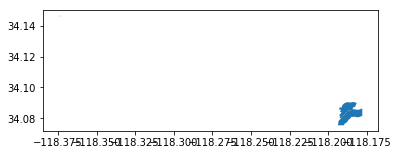

In [158]:
pd.concat(intersections).dissolve("GEOID")

In [148]:
testInt

""


In [143]:
df_buffers

,stop_id,stop_name,stop_lon,stop_lat,am_pk,pm_pk,wkdy,sat,sun,agency,buffer_dd,geometry
0,40113,Marin City Hub,-122.511070,37.871777,9.600000,8.571429,11.428571,15.000000,15.000000,Marin Transit,0.004587,"POLYGON ((-122.5064828290002 37.871777, -122.5..."
1,40158,Reed Blvd & Belvedere Dr,-122.513275,37.898609,14.117647,12.631579,16.551724,21.538462,21.538462,Marin Transit,0.004589,"POLYGON ((-122.5086861572565 37.898609, -122.5..."
2,40170,Hwy 101 @ Tiburon Wye Bus Pad,-122.515381,37.901730,10.434783,8.888889,11.566265,17.500000,17.500000,Marin Transit,0.004589,"POLYGON ((-122.510791962661 37.90173, -122.510..."
3,40182,Reed Blvd & Redwood Hwy,-122.514992,37.901085,13.333333,12.000000,14.117647,19.090909,19.090909,Marin Transit,0.004589,POLYGON ((-122.5104030028794 37.90108499999999...
4,40184,Redwood Hwy Frontage Rd & De Silva Island Dr,-122.516222,37.889215,15.000000,11.428571,15.000000,17.500000,17.500000,Marin Transit,0.004588,"POLYGON ((-122.5116337427944 37.889215, -122.5..."
5,40188,Hwy 101 @ Seminary Dr Bus Pad,-122.516382,37.888598,13.333333,12.000000,15.483871,24.705882,24.705882,Marin Transit,0.004588,POLYGON ((-122.5117937812431 37.88859799999999...
6,40414,2nd St & Grand Ave,-122.519966,37.970295,15.000000,12.631579,15.483871,24.705882,24.705882,Marin Transit,0.004593,"POLYGON ((-122.5153726799978 37.970295, -122.5..."
7,40429,3rd St & Grand Ave,-122.519012,37.971031,9.230769,8.571429,10.105263,18.666667,19.090909,Marin Transit,0.004593,"POLYGON ((-122.5144186339472 37.971031, -122.5..."
8,40430,San Rafael Transit Center,-122.523102,37.971081,12.631579,12.000000,13.714286,15.272727,15.000000,Marin Transit,0.004593,"POLYGON ((-122.5185086308187 37.971081, -122.5..."
9,40451,Francisco Blvd E & Bay St,-122.516441,37.966560,14.117647,12.631579,16.271186,23.333333,24.000000,Marin Transit,0.004593,"POLYGON ((-122.5118479136663 37.96656, -122.51..."


In [141]:
df[(np.abs(df["stop_lon"] - centroidXY[0]) <= searchDistance) & (np.abs(df["stop_lat"] - centroidXY[1]) <= searchDistance)]





,stop_id,stop_name,stop_lon,stop_lat,am_pk,pm_pk,wkdy,sat,sun,agency,buffer_dd,geometry,county
9626,118,9TH ST & K ST (SB),-121.495529,38.579250,10.434783,10.909091,12.467532,22.702703,25.454545,Sacramento Regional Transit,0.004632,POINT (-121.495529 38.57925),067
9627,119,9TH ST & L ST (SB),-121.496040,38.578034,6.153846,8.571429,8.807339,13.770492,30.000000,Sacramento Regional Transit,0.004632,POINT (-121.49604 38.578034),067
9629,324,8TH ST & Q ST (NB),-121.499344,38.573528,6.486486,5.581395,7.007299,20.487805,25.454545,Sacramento Regional Transit,0.004632,POINT (-121.499344 38.573528),067
9630,325,8TH ST & P ST (NB),-121.498848,38.574669,5.714286,5.714286,6.530612,20.487805,25.454545,Sacramento Regional Transit,0.004632,POINT (-121.498848 38.574669),067
9631,326,8TH ST & O ST (NB),-121.498346,38.575768,5.714286,5.714286,6.530612,26.250000,25.454545,Sacramento Regional Transit,0.004632,POINT (-121.498346 38.575768),067
9633,414,J ST & 6TH ST (EB),-121.498661,38.581602,7.058824,7.272727,8.000000,13.548387,22.105263,Sacramento Regional Transit,0.004632,POINT (-121.498661 38.581602),067
9634,880,T ST & 30TH ST (EB),-121.471077,38.561913,12.631579,12.631579,13.521127,21.538462,23.333333,Sacramento Regional Transit,0.004631,POINT (-121.471077 38.561913),067
9648,1911,BROADWAY & 37TH ST (WB),-121.466827,38.549542,9.600000,10.000000,10.909091,19.090909,23.333333,Sacramento Regional Transit,0.004630,POINT (-121.466827 38.549542),067
9649,1930,BROADWAY & 34TH ST (EB),-121.469299,38.552322,10.000000,10.000000,11.034483,18.666667,23.333333,Sacramento Regional Transit,0.004630,POINT (-121.469299 38.552322),067
9650,1931,BROADWAY & 35TH ST (EB),-121.468193,38.551025,10.000000,10.000000,11.034483,18.666667,23.333333,Sacramento Regional Transit,0.004630,POINT (-121.468193 38.551025),067


In [114]:
[float(x) for x in str(centroid)[7:-1].split()]

[-121.4973382361675, 38.54483131621232]

In [62]:
df.head()

,stop_id,stop_name,stop_lon,stop_lat,am_pk,pm_pk,wkdy,sat,sun,agency,buffer_dd,geometry,county
0,40113,Marin City Hub,-122.511070,37.871777,9.600000,8.571429,11.428571,15.000000,15.000000,Marin Transit,0.004587,POINT (-122.51107 37.871777),041
1,40158,Reed Blvd & Belvedere Dr,-122.513275,37.898609,14.117647,12.631579,16.551724,21.538462,21.538462,Marin Transit,0.004589,POINT (-122.513275 37.898609),041
2,40170,Hwy 101 @ Tiburon Wye Bus Pad,-122.515381,37.901730,10.434783,8.888889,11.566265,17.500000,17.500000,Marin Transit,0.004589,POINT (-122.515381 37.90173),041
3,40182,Reed Blvd & Redwood Hwy,-122.514992,37.901085,13.333333,12.000000,14.117647,19.090909,19.090909,Marin Transit,0.004589,POINT (-122.514992 37.90108499999999),041
4,40184,Redwood Hwy Frontage Rd & De Silva Island Dr,-122.516222,37.889215,15.000000,11.428571,15.000000,17.500000,17.500000,Marin Transit,0.004588,POINT (-122.516222 37.889215),041


In [51]:
checker.index

Index(['001', '003', '005', '007', '009', '011', '013', '015', '017', '019',
       '021', '023', '025', '027', '029', '031', '033', '035', '037', '039',
       '041', '043', '045', '047', '049', '051', '053', '055', '057', '059',
       '061', '063', '065', '067', '069', '071', '073', '075', '077', '079',
       '081', '083', '085', '087', '089', '091', '093', '095', '097', '099',
       '101', '103', '105', '107', '109', '111', '113', '115'],
      dtype='object', name='county')

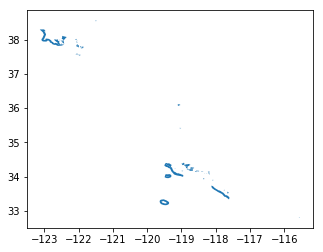

In [10]:
tracts.head(100).plot()

In [ ]:
%%time

testInt = gpd.overlay(tracts.head(1000), df_buffers.head(1000), how='intersection')
testInt["area"] = testInt["geometry"].area

In [16]:
testInt.head()

,GEOID,stop_id,stop_name,stop_lon,stop_lat,am_pk,pm_pk,wkdy,sat,sun,agency,buffer_dd,geometry,area
0,06041112202,40414,2nd St & Grand Ave,-122.519966,37.970295,15.000000,12.631579,15.483871,24.705882,24.705882,Marin Transit,0.004593,"POLYGON ((-122.521635 37.97012499999999, -122....",1.305402e-06
1,06041112202,40451,Francisco Blvd E & Bay St,-122.516441,37.966560,14.117647,12.631579,16.271186,23.333333,24.000000,Marin Transit,0.004593,"POLYGON ((-122.5197818732992 37.969705114683, ...",1.584109e-06
2,06041112202,40451,Francisco Blvd E & Bay St,-122.516441,37.966560,14.117647,12.631579,16.271186,23.333333,24.000000,Marin Transit,0.004593,POLYGON ((-122.5187964318905 37.96949604823955...,6.361879e-06
3,06041112202,40451,Francisco Blvd E & Bay St,-122.516441,37.966560,14.117647,12.631579,16.271186,23.333333,24.000000,Marin Transit,0.004593,POLYGON ((-122.5156069777813 37.96885958827075...,6.490245e-07
4,06041112202,40451,Francisco Blvd E & Bay St,-122.516441,37.966560,14.117647,12.631579,16.271186,23.333333,24.000000,Marin Transit,0.004593,POLYGON ((-122.5150455067114 37.96872473266219...,1.281941e-05


In [21]:
testInt[testInt["GEOID"] == "06041112202"]["area"].sum()

2.275450909387642e-05

In [22]:
testInt[["GEOID", "area"]].groupby(["GEOID"]).sum()

,area
GEOID,
06041109002,3.077494e-07
06041112201,1.312667e-06
06041112202,2.275451e-05
06041130202,4.233427e-06


In [11]:
gpd.overlay(tracts.head(100), df_buffers.head(100), how='intersection')["geometry"].area

0     1.305402e-06
1     1.584109e-06
2     6.361879e-06
3     6.490245e-07
4     1.281941e-05
5     1.312667e-06
6     1.399226e-18
7     3.468875e-08
8     9.066068e-07
9     3.305732e-06
10    2.108764e-08
11    3.077494e-07
dtype: float64

In [ ]:
tracts.head(100)[]